In [26]:
import pandas as pd
import sys
sys.path.append("../PycharmProjects/line_scraper")
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
%matplotlib inline
from dash_app.data_util import build_flat_dataset, build_sequence_dataset
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
from dash_app.data_util import *

In [33]:
def calc_payout(amount, line):
    if line > 0:
        return amount * (line / 100.)
    elif line < 0:
        return amount / (np.abs(line) / 100.)

def prob_to_ml(p):
    p *= 100
    if p >= 50:
        return -(p/(100.-p))*100.
    else:
        return (100-p/p)*100

In [6]:


def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=128, activation='sigmoid', inner_activation='hard_sigmoid',
                   input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(units=128, activation='sigmoid', inner_activation='hard_sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='mean_squared_error', optimizer='rmsprop')
    return model


def train_model(X, y):
    input_shape = X.shape[1:]

    model = build_model(input_shape)
#     
    print(X.shape)
    model.fit(X, y, batch_size=128, epochs=100, verbose=False)
#     pred = model.predict(X[N:])
#     true = y[N:]


#     
    return model

In [51]:
def backtest(pred, X_test, y_test, games_test, tol=.03, bankroll=1000.):
    games_bet = set([])
    balance = [bankroll]
    probs = []
    for p, x, y, g in zip(pred, X_test, y_test, games_test):
        if g not in games_bet:
            p_diffs = p - x[-1]
            if np.max(p_diffs) >= tol:
                odds = x[-1][np.argmax(p_diffs)]
                ml = prob_to_ml(odds)
                if y == 1:
                    bankroll += calc_payout(50, ml)
                else:
                    bankroll -= 50
                
                print("Betting on game {} - result: {}".format(g, y))
                print(p_diffs)
                games_bet |= set([g])
                balance.append(bankroll)
                probs.append(odds)
    return balance, probs, games_bet

In [52]:

X, y, game_ids = build_sequence_dataset(sequence_length=4)
X_train, X_test, y_train, y_test, games_train, games_test = train_test_split(X, y, game_ids, test_size=.33)

In [ ]:
model = train_model(X_train, y_train)

/home/ben/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=128, input_shape=(5, 23), recurrent_activation="hard_sigmoid", return_sequences=True, activation="sigmoid")`
/home/ben/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=128, recurrent_activation="hard_sigmoid", activation="sigmoid")`


(1513, 5, 23)


In [ ]:
pred = model.predict_proba(X_test)

In [ ]:
base_x, base_y = build_flat_dataset()
print("MSE: {}".format(mse(y_test, pred)))
print("Baseline MSE: {}".format(mse(base_y, base_x.mean(axis=1))))

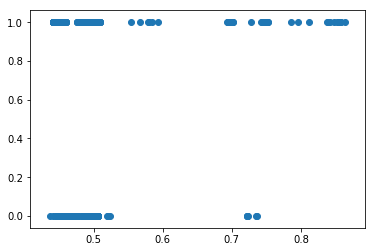

In [11]:
plt.scatter(pred, y_test)

In [50]:
balance, probs, games_bet = backtest(pred, X_test, y_test, games_test, tol=.02)

Betting on game 7276 - result: 1.0
Betting on game 18466 - result: 1.0
Betting on game 139 - result: 1.0
Betting on game 18458 - result: 1.0
Betting on game 24203 - result: 1.0
Betting on game 6664 - result: 1.0
Betting on game 18314 - result: 1.0
Betting on game 12549 - result: 0.0
Betting on game 13818 - result: 0.0
Betting on game 13580 - result: 1.0
Betting on game 129 - result: 0.0
Betting on game 7960 - result: 1.0
Betting on game 18312 - result: 0.0
Betting on game 13816 - result: 0.0
Betting on game 7919 - result: 1.0
Betting on game 123 - result: 0.0


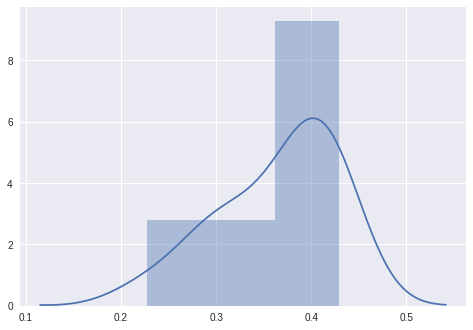

In [47]:
sns.distplot(probs)

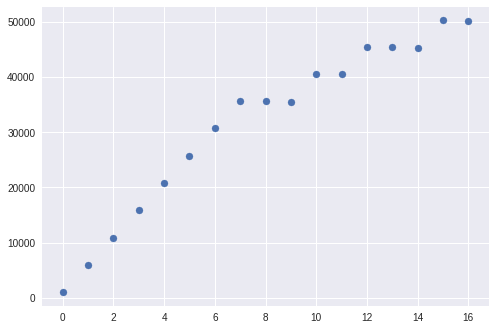

In [46]:
plt.scatter(range(len(balance)), balance)

In [40]:
df = get_data()

In [42]:
df.loc[df.game_id.isin(games_bet)]

,away_prob,bookie,game_id,home_prob,line_datetime,outcome,time_to_game
771,0.60784,5Dimes,123,0.42553,2018-04-01 15:50:32,0.0,189.466667
772,0.61538,5Dimes,123,0.41667,2018-04-01 16:41:29,0.0,138.516667
773,0.61538,Bet365,123,0.41667,2018-04-01 15:50:32,0.0,189.466667
774,0.60784,Bet365,123,0.42553,2018-04-01 17:02:51,0.0,117.150000
775,0.61538,Bet365,123,0.41667,2018-04-01 17:32:20,0.0,87.666667
776,0.60784,BetDSI,123,0.42553,2018-04-01 15:50:32,0.0,189.466667
777,0.61538,BetDSI,123,0.41667,2018-04-01 16:17:26,0.0,162.566667
778,0.61240,BetDSI,123,0.42017,2018-04-01 16:41:29,0.0,138.516667
779,0.61538,BetDSI,123,0.41667,2018-04-01 16:44:10,0.0,135.833333
780,0.62264,BetDSI,123,0.40816,2018-04-01 18:38:17,0.0,21.716667


In [80]:
offset = pred.argmin()
X[N+offset]

array([[ 0.44643,  0.46512,  0.45249,  0.44843,  0.45249,  0.45249,
         0.46729,  0.46512,  0.45045,  0.44643,  0.45662,  0.45249,
         0.44643,  0.45872,  0.45045,  0.46512,  0.45455,  0.44843,
         0.44643,  0.45249,  0.44843,  0.45455,  0.45045],
       [ 0.44843,  0.45455,  0.45662,  0.45455,  0.45455,  0.46083,
         0.46512,  0.44444,  0.45455,  0.44843,  0.46083,  0.45045,
         0.44444,  0.44843,  0.45249,  0.46512,  0.46083,  0.45455,
         0.44843,  0.45455,  0.44843,  0.45045,  0.45662],
       [ 0.45455,  0.46512,  0.46083,  0.45455,  0.45455,  0.46083,
         0.46512,  0.44444,  0.45455,  0.44843,  0.46083,  0.45045,
         0.44444,  0.44843,  0.45249,  0.46512,  0.46083,  0.45455,
         0.45455,  0.45455,  0.44843,  0.45045,  0.45455],
       [ 0.45455,  0.46512,  0.46083,  0.45045,  0.45455,  0.46083,
         0.46512,  0.44444,  0.45455,  0.45455,  0.46083,  0.45045,
         0.44444,  0.44248,  0.45249,  0.46512,  0.45662,  0.45045,
       

In [81]:
print("Pred: {}, true: {}".format(pred[offset], true[offset]))

Pred: [ 0.45868504], true: 1.0


In [82]:
X[N:].shape

(605, 11, 23)

In [79]:
X[N].mean(axis=-1).shape

(11,)